# 05 Machine Learning Strategy

#### Purpose
Compare machine learning strategy with manual strategy

In [1]:
!conda env list

# conda environments:
#
base                     /home/ubuntu/anaconda3
alert                    /home/ubuntu/anaconda3/envs/alert
aws_neuron_mxnet_p36     /home/ubuntu/anaconda3/envs/aws_neuron_mxnet_p36
aws_neuron_tensorflow_p36     /home/ubuntu/anaconda3/envs/aws_neuron_tensorflow_p36
chainer_p27              /home/ubuntu/anaconda3/envs/chainer_p27
chainer_p36              /home/ubuntu/anaconda3/envs/chainer_p36
ml                    *  /home/ubuntu/anaconda3/envs/ml
mxnet_p27                /home/ubuntu/anaconda3/envs/mxnet_p27
mxnet_p36                /home/ubuntu/anaconda3/envs/mxnet_p36
python2                  /home/ubuntu/anaconda3/envs/python2
python3                  /home/ubuntu/anaconda3/envs/python3
pytorch_p27              /home/ubuntu/anaconda3/envs/pytorch_p27
pytorch_p36              /home/ubuntu/anaconda3/envs/pytorch_p36
tensorflow2_p27          /home/ubuntu/anaconda3/envs/tensorflow2_p27
tensorflow2_p36          /home/ubuntu/anaconda3/envs/tensorflow2_p36
tensorflo

In [2]:
import sys
from pathlib import Path
# add project folder to sys path
sys.path.append(str(Path.cwd().parent))

In [3]:
# import libraries
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# import helper functions
import util as ut
import ManualStrategy as ms
import StrategyLearner as sl
import indicators as ind
import marketsimcode as sim

In [4]:
pd.options.mode.chained_assignment = None

In [5]:
CURRENT_DIR = Path.cwd()
PROJECT_DIR = Path.cwd().parent
ORDER_DIR = PROJECT_DIR / "orders"

In [6]:
# example orders file
orders_file = str(ORDER_DIR/"orders.csv")
df_orders = pd.read_csv(orders_file, index_col='Date', parse_dates=True, na_values=['nan'])
df_orders

,Symbol,Order,Shares
Date,,,
2011-01-10,AAPL,BUY,1500
2011-01-13,AAPL,SELL,1500
2011-01-13,IBM,BUY,4000
2011-01-26,GOOG,BUY,1000
2011-02-02,XOM,SELL,4000
2011-02-10,XOM,BUY,4000
2011-03-03,GOOG,SELL,1000
2011-03-03,IBM,SELL,2200
2011-06-03,IBM,SELL,3300


In [7]:
SYMBOL = "JPM"
IN_SAMPLE_DATES = (dt.datetime(2008, 1, 1), dt.datetime(2009, 12, 31))
OUT_SAMPLE_DATES = (dt.datetime(2010, 1, 1), dt.datetime(2011, 12, 31))
START_VAL = 100000
POSITIONS = [-1000, 0, 1000]
ACTIONS = [-1, 0, 1]  # [SHORT, CASH, LONG]

IMPACT = 0.005
TRANSACTION_COMMISSION = 0.0

# fix random seed
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

In [8]:
def plot_compare(benchmark_portvals,
                 manual_strategy_portvals,
                 strategy_learner_portval):
    """Plot portfolio values of Benchmark and Manual Strategy"""
    final_df = pd.concat([benchmark_portvals, manual_strategy_portvals, strategy_learner_portval], axis=1)
    final_df.columns = ['Normalized Benchmark Portfolio Value',
                        'Normalized Manual Strategy Portfolio Value',
                        'Normalized Strategy Learner Portfolio Value']
    # print(final_df)
    # Plot final dataframe
    title = "Strategy Learner vs Manual Strategy"
    xlabel = "Date"
    ylabel = "Portfolio Value"
    """Plot stock prices with a custom title and meaningful axis labels."""
    ax = final_df.plot(title=title, fontsize=12, color=['g', 'r', 'b'], figsize=(10, 6))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.axhline(y=1., color='m', linestyle=':')
    plt.show()
    return None

In [9]:
def print_performance(title, cr, adr, sddr, sr, final_portval):
    print(title)
    print("final strategy_portvals", final_portval[-1])
    print("cum_ret", cr)
    print("avg_daily_ret", adr)
    print("std_daily_ret", sddr)
    print("sharpe_ratio", sr)

In [10]:
def get_prices(symbol, sd, ed):
    """ Get price data based on symbol and start_date, end_date """

    # get symbol list and date range
    syms = [symbol]
    dates = pd.date_range(sd, ed)

    # Get prices data, automatically adds SPY
    prices_all = ut.get_data(syms, dates)

    # normalize price, price[t] /= price[0]
    prices_all = ind.normalize(prices_all)

    prices = prices_all[syms]  # only portfolio symbols
    prices_SPY = prices_all['SPY']  # only SPY, for comparison later
    # if self.verbose: print prices

    return prices

In [11]:
def test_code():
    # Test in sample performance
    prices = get_prices(symbol=SYMBOL, sd=IN_SAMPLE_DATES[0], ed=IN_SAMPLE_DATES[1])
    # Strategy Learner
    st_learner = sl.StrategyLearner(verbose=False, impact=IMPACT)
    st_learner.addEvidence(symbol=SYMBOL,
                           sd=IN_SAMPLE_DATES[0],
                           ed=IN_SAMPLE_DATES[1],
                           sv=START_VAL)
    # Test in sample performance
    st_trades = st_learner.testPolicy(symbol=SYMBOL,
                                      sd=IN_SAMPLE_DATES[0],
                                      ed=IN_SAMPLE_DATES[1],
                                      sv=START_VAL)
    st_orders = st_learner.convert_trades_to_order(st_trades)
    st_portval = sim.compute_portvals(st_orders,
                                      start_val=START_VAL,
                                      commission=TRANSACTION_COMMISSION,
                                      impact=IMPACT,
                                      start_date=IN_SAMPLE_DATES[0],
                                      end_date=IN_SAMPLE_DATES[1])
    st_portval = st_learner.normalize_df(st_portval)
    st_cr, st_adr, st_sddr, st_sr = sim.get_portfolio_stats(st_portval)

    print_performance("Strategy Learner", st_cr, st_adr, st_sddr, st_sr, st_portval)

    # Benchmark
    ben_portvals, ben_cr, ben_adr, ben_sddr, ben_sr = ms.benchmark(SYMBOL, IN_SAMPLE_DATES[0], IN_SAMPLE_DATES[1],
                                                                   START_VAL)
    print_performance("Benchmark", ben_cr, ben_adr, ben_sddr, ben_sr, ben_portvals)

    # Manual strategy
    ms_trades = ms.testPolicy(SYMBOL, IN_SAMPLE_DATES[0], IN_SAMPLE_DATES[1], START_VAL)
    ms_orders = ms.convert_trades_to_order(ms_trades)
    ms_portvals = ms.compute_portvals(df_orders=ms_orders,
                                      start_val=START_VAL,
                                      commission=TRANSACTION_COMMISSION,
                                      impact=IMPACT,
                                      start_date=IN_SAMPLE_DATES[0],
                                      end_date=IN_SAMPLE_DATES[1])
    ms_portvals = ms.normalize(ms_portvals)
    ms_cr, ms_adr, ms_sddr, ms_sr = ms.get_portfolio_stats(ms_portvals)
    print_performance("Manual Strategy", ms_cr, ms_adr, ms_sddr, ms_sr, ms_portvals)

    plot_compare(ben_portvals,
                 ms_portvals,
                 st_portval)

Strategy Learner
final strategy_portvals 1.665661499999999
cum_ret 0.665661499999999
avg_daily_ret 0.001036529846434984
std_daily_ret 0.006936496835125607
sharpe_ratio 2.3721485920175827
Benchmark
final strategy_portvals 1.0123249333401472
cum_ret 0.01232493334014717
avg_daily_ret 0.00016875916214640062
std_daily_ret 0.017041247068174333
sharpe_ratio 0.15720496488905208
Manual Strategy
final strategy_portvals 1.1502469999999998
cum_ret 0.1502469999999998
avg_daily_ret 0.00040456453323080044
std_daily_ret 0.01596266460857435
sharpe_ratio 0.402330251415796


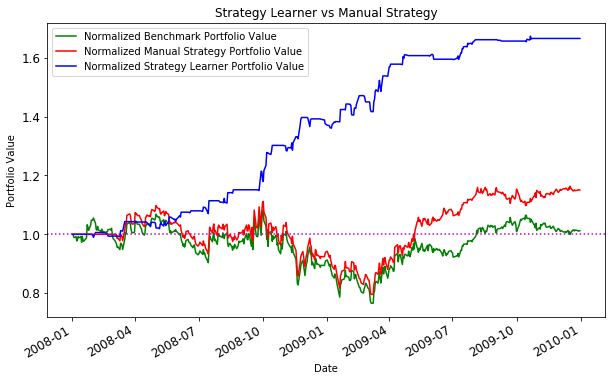

In [12]:
test_code()